In [ ]:
#This notebook analysis PISA data from the original camera source
#Tif files comprising frame series data are analyzed for frame-to-frame bead motion

In [115]:
base_dir = './'
sub = '/'
run = '/'
saveprefix = ''
filename = base_dir + sub + run + saveprefix + '.tif'
d_count = 1
d_frames = 240
t_interval = 1

In [116]:
import tifffile
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imageio
from PIL import Image, ImageDraw, ImageFont
import json

In [117]:
def get_ims(name):
    tf = tifffile.TiffFile(name)

    images = []

    for page in tf.pages:
        image = page.asarray()
        sampled_im = image[::1, ::1]
        sampled_im = sampled_im[250:750,250:750]
        quantized_image = (sampled_im/65535*255).astype(np.uint8)
        images.append(quantized_image)

    return images

In [118]:
def binarize(ims):
    binarized_ims = []

    for im in ims:
        binarized = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, 15)

        binarized_ims.append(binarized)

    return binarized_ims

In [119]:
def get_beads(im):
    beads = {}
    contours, _ = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    count = 0

    for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (float(x), float(y))
        radius = float(radius)

        if 10 > radius > 5:
            if 10 <= center[0] <= 490 and 10 <= center[1] <= 490:
                beads[count] = {'centers':[center],
                                'radii':[radius],
                                'viable':True,
                                'travel':[0],
                                'travel_um':[0],
                                'integrated_travel':[0],
                                'distance_from_start':[0]}
                count += 1

    return beads

In [120]:
def match_beads(prev_beads, current_beads, max_distance_threshold):
    matched_beads = prev_beads.copy()
    frame_vector = (0,0)
    bead_count = 0

    for bead in prev_beads:
        if prev_beads[bead]['viable']:
            min_dist = 10*max_distance_threshold
            closest_current_center = None
            radius = None
            r_change = 0

            for c_bead in current_beads:
                distance = np.linalg.norm(np.array(current_beads[c_bead]['centers'][0]) - np.array(prev_beads[bead]['centers'][-1]))

                if distance < min_dist:
                    min_dist = distance
                    closest_current_center = current_beads[c_bead]['centers'][0]
                    radius = current_beads[c_bead]['radii'][0]
                    r_change = abs(radius - prev_beads[bead]['radii'][-1])

            if closest_current_center is not None and min_dist < max_distance_threshold and r_change < 5:
                matched_beads[bead]['centers'].append(closest_current_center)
                matched_beads[bead]['radii'].append(radius)

                frame_vector = np.add(frame_vector, np.subtract(matched_beads[bead]['centers'][-1], matched_beads[bead]['centers'][-2]))
                bead_count += 1
            else:
                matched_beads[bead]['viable'] = False

    frame_average = np.divide(frame_vector, bead_count)

    for bead in matched_beads:
        if matched_beads[bead]['viable']:
            corrected_distance = np.linalg.norm(np.subtract(np.subtract(matched_beads[bead]['centers'][-1], matched_beads[bead]['centers'][-2]), frame_average))
            matched_beads[bead]['travel'].append(corrected_distance)
            matched_beads[bead]['travel_um'].append(corrected_distance*.2) #scale factor for conversion to microns
            matched_beads[bead]['integrated_travel'].append(matched_beads[bead]['integrated_travel'][-1] + corrected_distance)
            matched_beads[bead]['distance_from_start'].append(np.linalg.norm(np.subtract(matched_beads[bead]['centers'][-1], matched_beads[bead]['centers'][0])))

    return matched_beads

In [121]:
binaries = binarize(get_ims(filename))

In [122]:
beads = get_beads(binaries[0])

In [123]:
for i in range(1,len(binaries)):
    beads = match_beads(beads, get_beads(binaries[i]),50)

In [124]:
with open(base_dir + sub + run + saveprefix + '.json', 'w') as f:
    json.dump(beads, f)

In [125]:
times = np.arange(0,d_count,t_interval)

In [126]:
#save combo file with overlay as gif
tf = tifffile.TiffFile(filename)

images = []
imcount = 0

for page in tf.pages:
    if imcount % 8 == 0:
        image = page.asarray()
        sampled_im = image[::1, ::1]
        sampled_im = sampled_im[250:750,250:750]
        quantized_image = (sampled_im/65535*255).astype(np.uint8)
        image = cv2.cvtColor(quantized_image, cv2.COLOR_GRAY2RGB)
        image = Image.fromarray(image, 'RGB')
        draw_im = ImageDraw.Draw(image,'RGBA')

        for bead in beads:
            if len(beads[bead]['centers']) > imcount:
                center = tuple(t for t in beads[bead]['centers'][imcount])
                draw_im.circle(center, beads[bead]['radii'][imcount]/2-1,fill=None, outline=(0,0,255,255),width=2)

        time = int(imcount/8)
        label = 'Time: %s s'%time
        font = ImageFont.truetype("arial.ttf", 40)
        draw_im.rectangle((5,5,250,60), fill=(0,0,0))
        draw_im.text((10,10),label,fill=(255,255,255),font=font)

        images.append(image)

    imcount += 1

imageio.mimsave(base_dir + sub + run + saveprefix + '8x_overlay' + '.gif', images, loop=0, optimize=False, duration=.1)

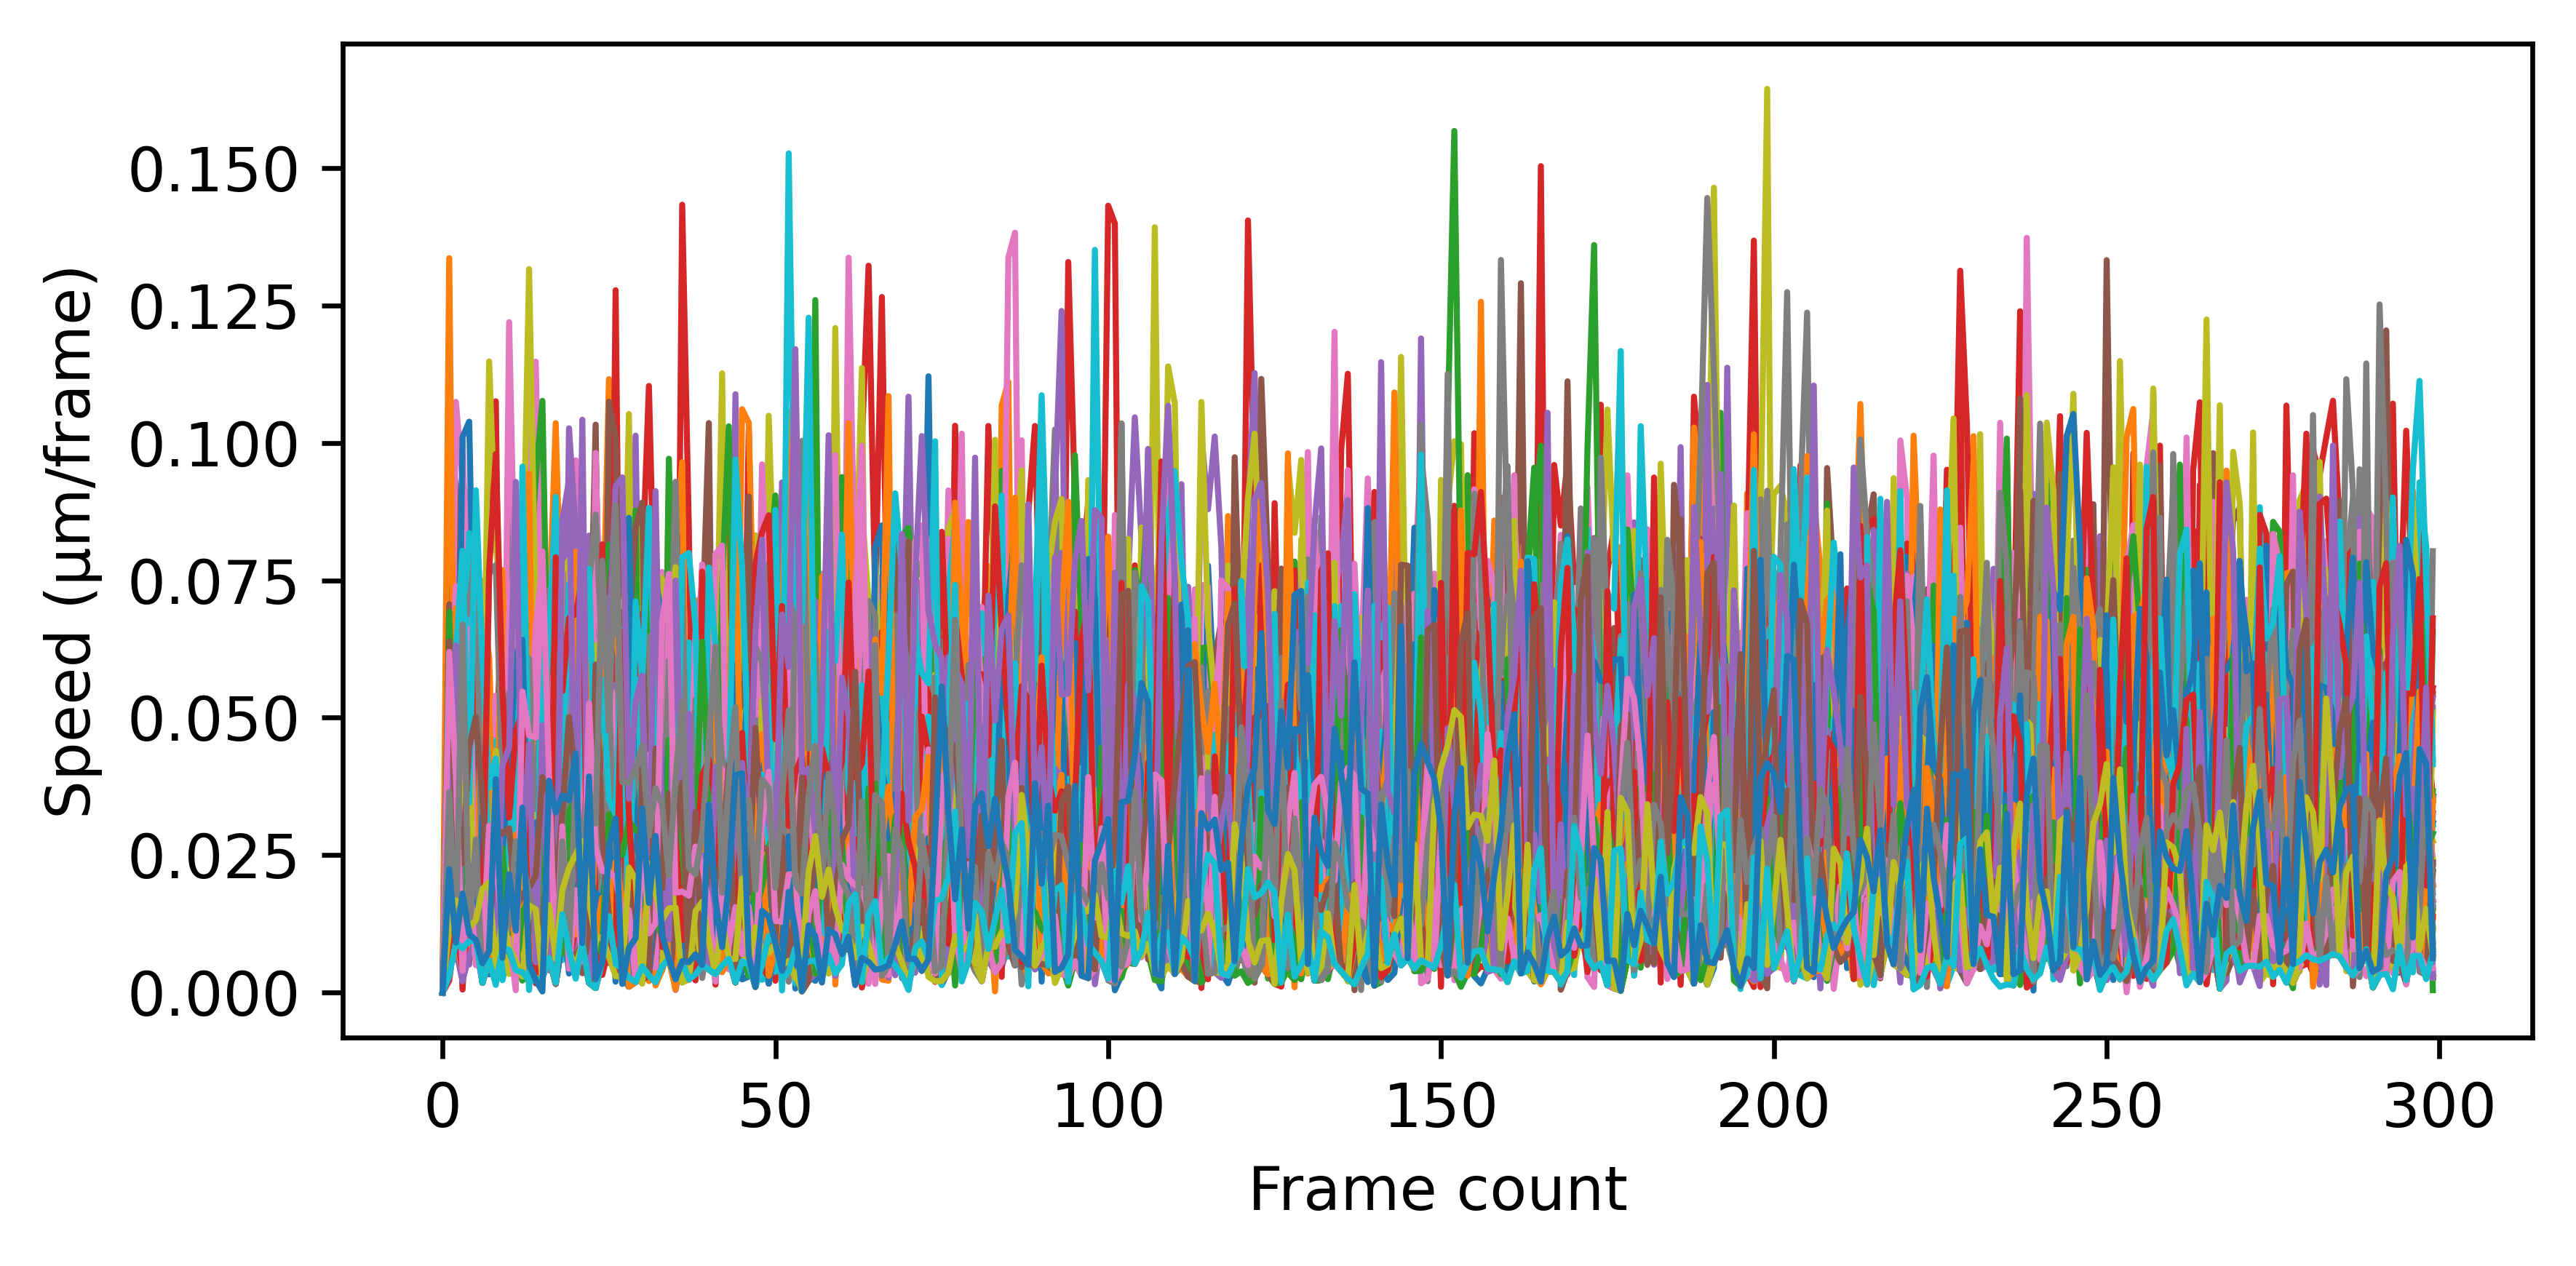

In [127]:
#plot bead travel per frame
matplotlib.rcParams['pdf.fonttype']=42
fig = plt.figure(figsize=(6,3),dpi=600)

for bead in beads:
    plt.plot(beads[bead]['travel_um'],linewidth=1)

plt.xlabel('Frame count')
plt.ylabel('Speed (μm/frame)')
plt.tight_layout()
fig.savefig(base_dir + sub + 'plots/' + saveprefix + 'travel.jpg', format='jpg')

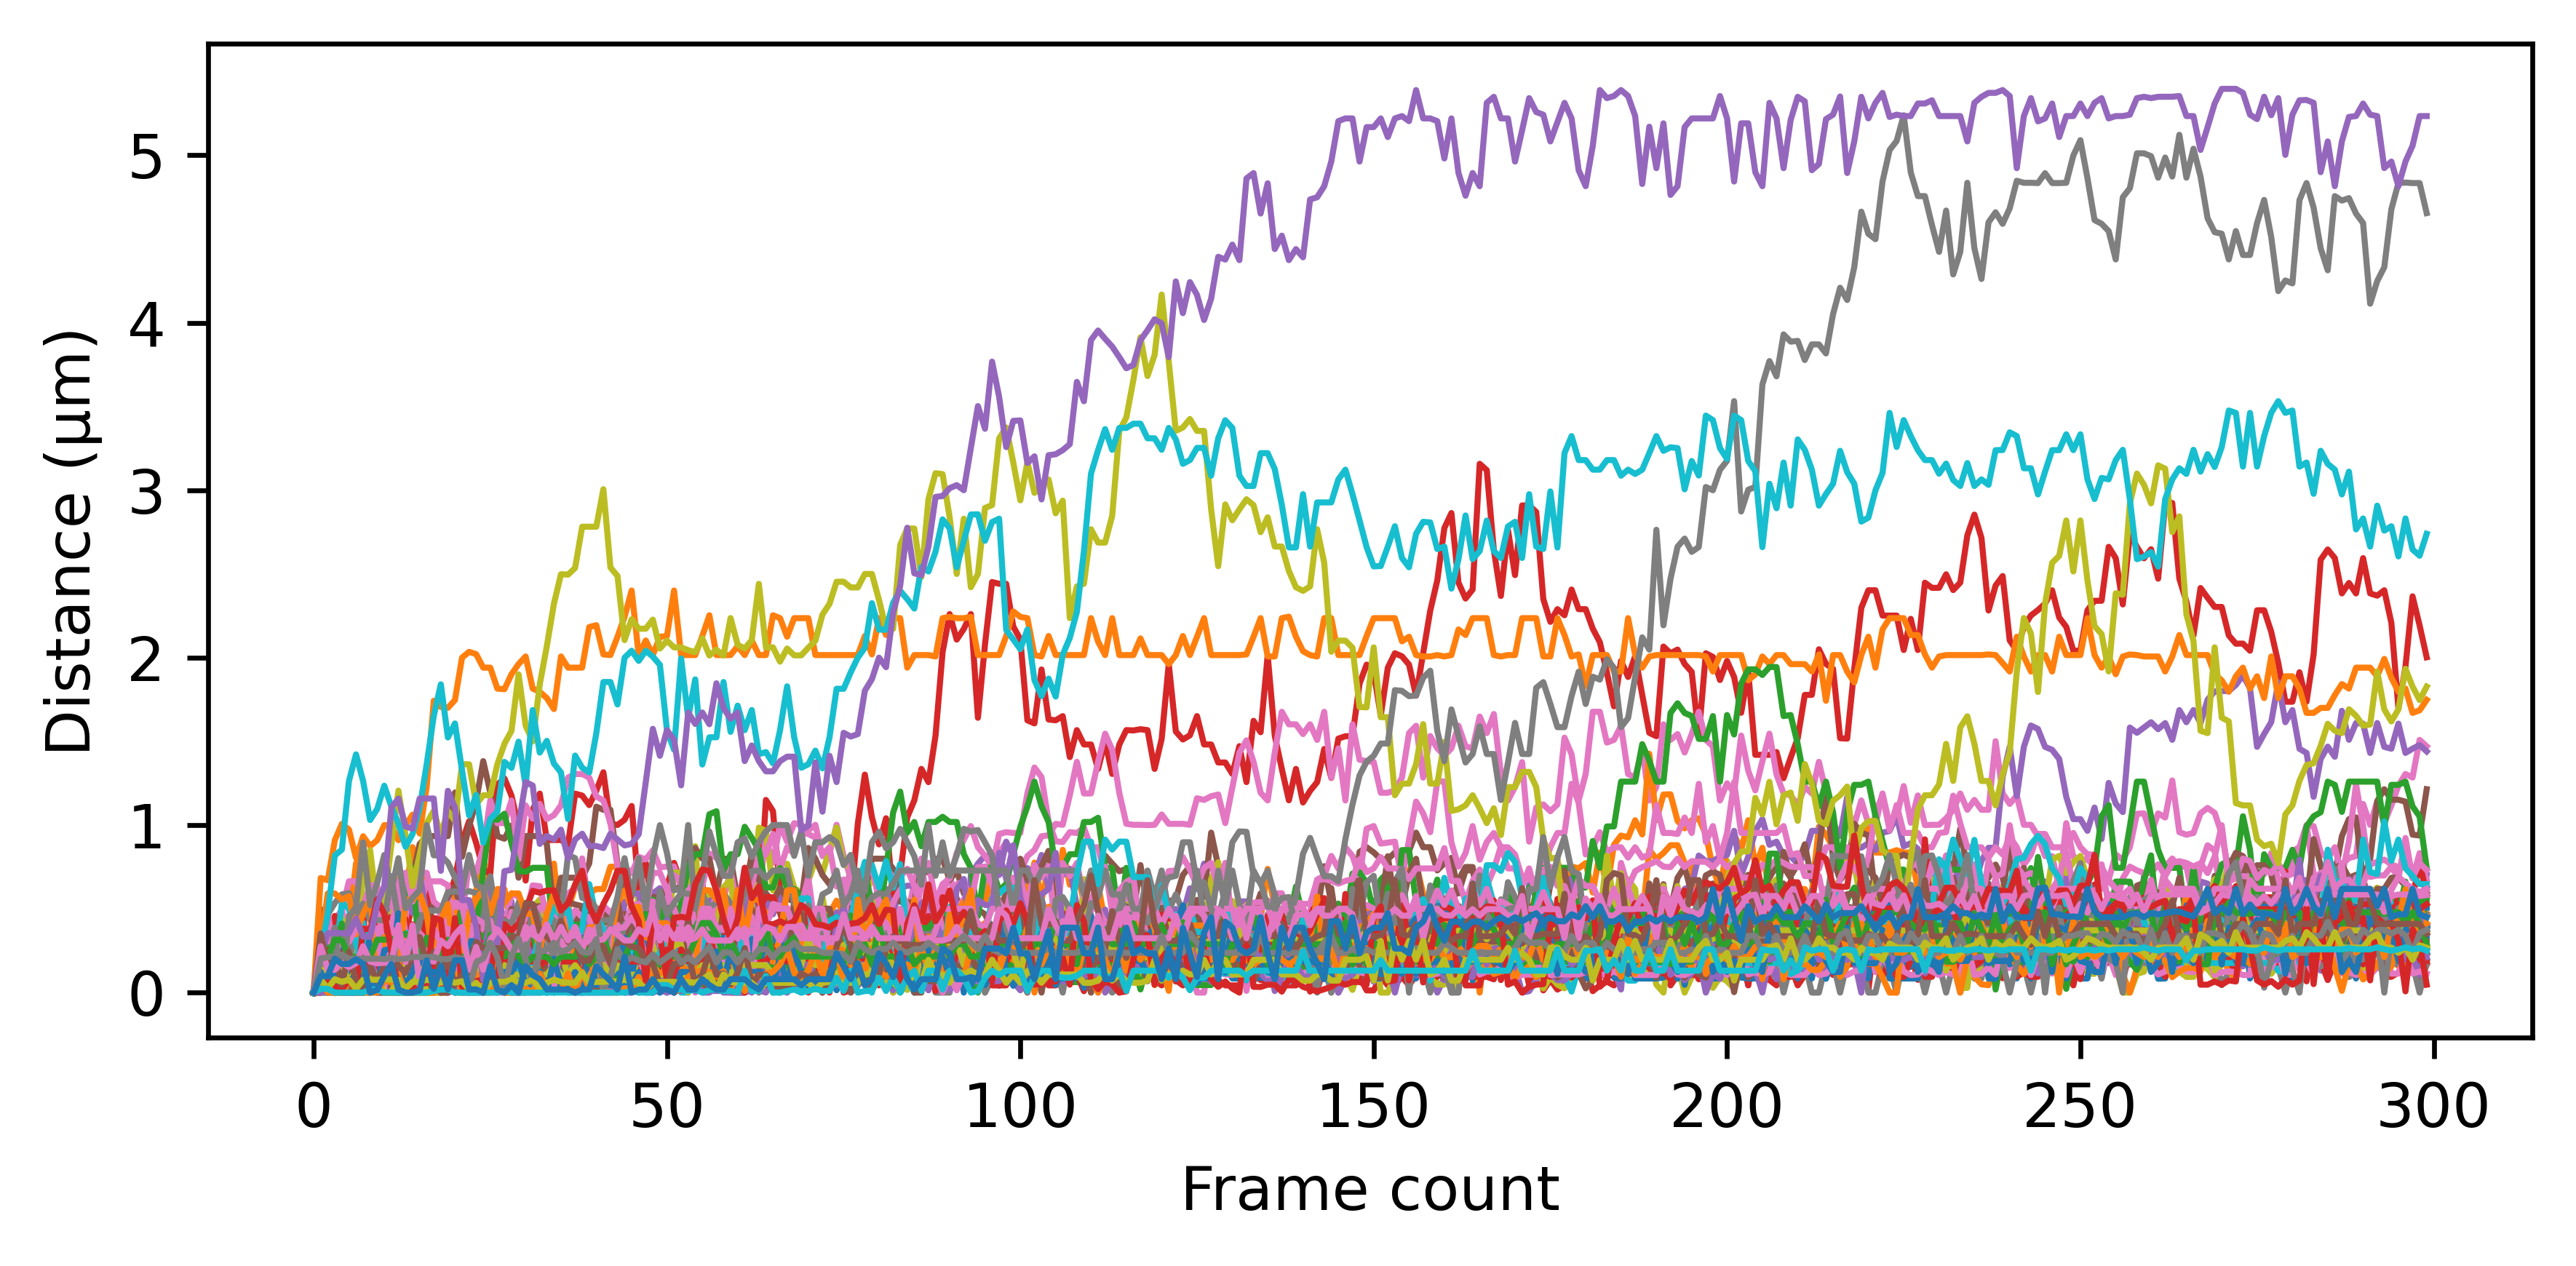

In [128]:
#plot bead distance from starting coordinate
matplotlib.rcParams['pdf.fonttype']=42
fig = plt.figure(figsize=(6,3),dpi=600)

for bead in beads:
    plt.plot(beads[bead]['distance_from_start'],linewidth=1)

plt.xlabel('Frame count')
plt.ylabel('Distance (μm)')
plt.tight_layout()
fig.savefig(base_dir + sub + 'plots/' + saveprefix + 'distance_from_start.jpg', format='jpg')

In [134]:
#pdf export
! jupyter nbconvert --execute --to pdf basic-pipeline-emily-export.ipynb

[NbConvertApp] Converting notebook basic-pipeline-emily-export.ipynb to pdf
[NbConvertApp] Support files will be in basic-pipeline-emily-export_files\
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Making directory .\basic-pipeline-emily-export_files
[NbConvertApp] Writing 66056 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 6094693